## Extracting our data

In [1]:
import tarfile
import os

tar_file = "data/ztf_public_20250302.tar.gz"
extract_dir = "data/avro_data"

In [2]:
try:
    with tarfile.open(tar_file, "r:gz") as tar:
        tar.extractall(path=extract_dir)
    print(f"Extracted to: {extract_dir}")
except tarfile.ReadError as e:
    print("Extraction failed:", e)

Extracted to: data/avro_data


In [3]:
def find_files(root_dir):
  for dir_name, subdir_list, file_list in os.walk(root_dir, followlinks=True):
    for fname in file_list:
      if fname.endswith('.avro'):
        yield f"{dir_name}/{fname}"

files_gen = list(find_files(extract_dir))
print(f'{extract_dir} has {len(files_gen)} avro files')

data/avro_data has 38368 avro files


In [4]:
import fastavro

with open(files_gen[0], 'rb') as f:
    reader = fastavro.reader(f)
    packet = next(reader)
    print(packet.keys())

dict_keys(['schemavsn', 'publisher', 'objectId', 'candid', 'candidate', 'prv_candidates', 'fp_hists', 'cutoutScience', 'cutoutTemplate', 'cutoutDifference'])


In [5]:
import gzip
import io
from astropy.io import fits

files = files_gen[:400]
shapes = {}
for fn in files:
    with open(fn,'rb') as f:
        pkt = next(fastavro.reader(f))
    stamp = pkt['cutoutDifference']['stampData']
    with gzip.open(io.BytesIO(stamp),'rb') as g:
        data = fits.open(io.BytesIO(g.read()))[0].data
    shapes[data.shape] = shapes.get(data.shape,0) + 1

print("Stamp shape distribution:")
for shape, cnt in sorted(shapes.items()):
    print(f"  {shape}: {cnt}")

Stamp shape distribution:
  (55, 63): 1
  (63, 42): 1
  (63, 52): 1
  (63, 61): 1
  (63, 63): 396


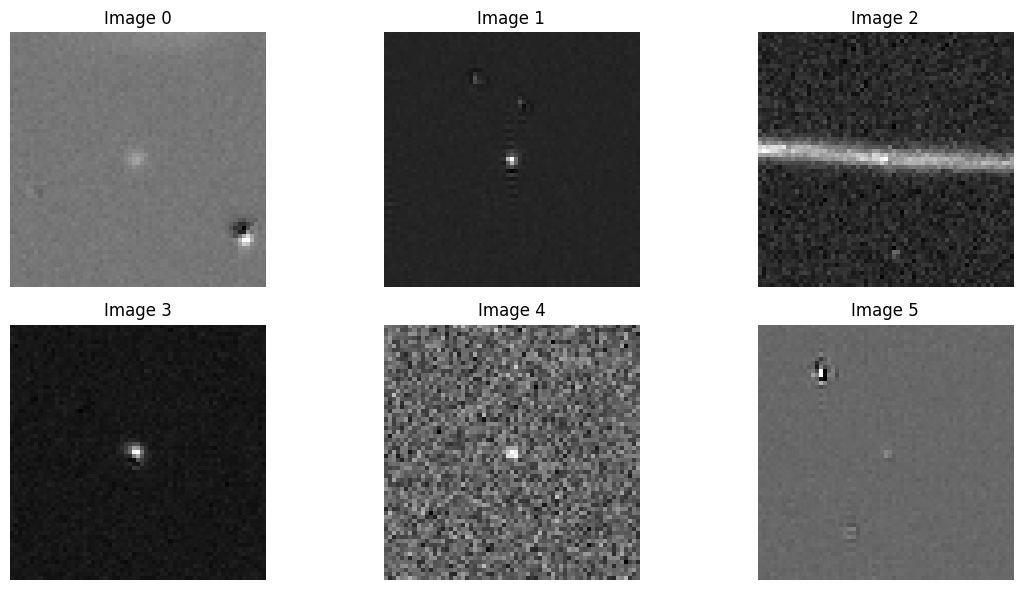

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def get_difference_image(avro_path):
    with open(avro_path, 'rb') as f:
        reader = fastavro.reader(f)
        for packet in reader:
          stamp = packet['cutoutDifference']['stampData']
          with gzip.open(io.BytesIO(stamp), 'rb') as gf:
              with fits.open(io.BytesIO(gf.read())) as hdul:
                  data = hdul[0].data
                  return data.astype(np.float32)

plt.figure(figsize=(12, 6))
count = 0
for i, path in enumerate(files_gen):
    img = get_difference_image(path)
    if img is not None and img.shape == (63, 63):
        plt.subplot(2, 3, count + 1)
        plt.imshow(img, cmap='gray', origin='lower')
        plt.title(f"Image {i}")
        plt.axis('off')
        count += 1
        if count == 6:
            break

plt.tight_layout()
plt.show()

In [7]:
# Extract image from Avro file stamp data
def extract_image(stamp_data):
  with gzip.open(io.BytesIO(stamp_data), 'rb') as f:
    with fits.open(io.BytesIO(f.read())) as hdul:
      data = hdul[0].data
      return data.astype(np.float32)

In [8]:
# Normalize image from 0 to 1
def normalize_image(img):
  img = np.nan_to_num(img, nan=0.0)
  min_val = np.min(img)
  max_val = np.max(img)
  normalized_image = (img - min_val) / float(max_val - min_val)
  return normalized_image

In [9]:
# Pad img shapes to 63, 63
def pad_image(img):
  h, w = img.shape
  pad_h = 63 - h
  pad_w = 63 - w
  pad_top = pad_h // 2
  pad_bottom = pad_h - pad_top
  pad_left = pad_w // 2
  pad_right = pad_w - pad_left
  return np.pad(img, ((pad_top, pad_bottom), (pad_left, pad_right)), 'constant', constant_values=0)

In [10]:
# Combine pad and normalize
def preprocess_image(img):
  img = normalize_image(img)
  if img.shape != (63, 63):
    img = pad_image(img)
  return img

In [11]:
with open(files_gen[0], 'rb') as f:
  reader = fastavro.reader(f)
  packet = next(reader)

  sci = extract_image(packet['cutoutScience']['stampData'])
  temp = extract_image(packet['cutoutTemplate']['stampData'])
  diff = extract_image(packet['cutoutDifference']['stampData'])
  print(f"Raw: \n{sci}")
  print(f"Raw img shape: {sci.shape}")


  norm_sci = normalize_image(sci)
  norm_temp = normalize_image(temp)
  norm_diff = normalize_image(diff)
  print(f"Normalized: \n{norm_sci}")
  print(f"Normalized img shape: {norm_sci.shape}")

  padded_sci = pad_image(norm_sci)
  padded_temp = pad_image(norm_temp)
  padded_diff = pad_image(norm_diff)
  print(f"Padded: \n{padded_sci}")
  print(f"Padded img shape: {padded_diff.shape}")

Raw: 
[[262.63446 245.46739 249.26234 ... 266.5089  255.8499  269.38647]
 [257.85284 260.5993  258.98938 ... 254.86292 274.33823 261.6112 ]
 [256.565   260.56366 254.47581 ... 262.78696 254.39893 257.23953]
 ...
 [260.90192 265.1819  255.644   ... 252.2644  261.36847 258.38885]
 [263.8446  258.8421  257.81503 ... 255.70964 260.1333  246.99583]
 [249.77328 256.4133  249.73474 ... 256.99524 259.61316 259.47778]]
Raw img shape: (63, 63)
Normalized: 
[[0.00352637 0.00111746 0.00164998 ... 0.00407004 0.00257435 0.00447382]
 [0.00285541 0.00324079 0.00301489 ... 0.00243586 0.00516866 0.00338278]
 [0.00267469 0.00323579 0.00238154 ... 0.00354777 0.00237075 0.00276935]
 ...
 [0.00328326 0.00388383 0.00254546 ... 0.00207123 0.00334872 0.00293062]
 [0.00369618 0.00299422 0.0028501  ... 0.00255467 0.0031754  0.00133194]
 [0.00172167 0.00265341 0.00171626 ... 0.00273507 0.00310242 0.00308342]]
Normalized img shape: (63, 63)
Padded: 
[[0.00352637 0.00111746 0.00164998 ... 0.00407004 0.00257435 0.00

In [13]:
save_dir = "data/ztf_chunks"
os.makedirs(save_dir, exist_ok=True)

chunk_size = 1000
total_files = 38368
img_shape = (63, 63, 3)

files = list(files_gen)

In [14]:
import gc

def process_chunks(start, stop):
  images = np.zeros((chunk_size, *img_shape), dtype=np.float32)
  labels = np.zeros((chunk_size, 1), dtype=np.int8)

  for i in range(chunk_size):
    file_id = start + i
    if file_id >= total_files:
        images = images[:i]
        labels = labels[:i]
        break

    avro_file = files[file_id]
    try:
      with open(avro_file, 'rb') as f:
        reader = fastavro.reader(f)
        packet = next(reader, None)
        if packet is None:
          continue

        sci = extract_image(packet['cutoutScience']['stampData'])
        temp = extract_image(packet['cutoutTemplate']['stampData'])
        diff = extract_image(packet['cutoutDifference']['stampData'])

        if any(x is None for x in (sci, temp, diff)):
          continue

        sci = preprocess_image(sci)
        temp = preprocess_image(temp)
        diff = preprocess_image(diff)

        stacked_img = np.stack((sci, temp, diff), axis=-1)

        rb_score = packet['candidate'].get('rb',0)
        if rb_score > 0.7:
          label = 1
        else:
          label = 0

        images[i] = stacked_img
        labels[i] = label

    except Exception as e:
      print(f"Skipping {avro_file} due to error: {e}")

    finally:
      gc.collect()

  save_path = os.path.join(save_dir, f"ztf_chunk_{stop:03}.npz")
  np.savez_compressed(save_path, images=images, labels=labels)
  print(f"Saved chunk {stop} with {images.shape[0]} samples")

In [15]:
existing = set()
for f in os.listdir(save_dir):
  if f.startswith("ztf_chunk_") and f.endswith(".npz"):
    existing.add(int(f.split('_')[-1].split('.')[0]))

for stop in range((total_files + chunk_size - 1) // chunk_size):
    if stop in existing:
        print(f"Skipping chunk {stop}")
        continue

    start = stop * chunk_size
    process_chunks(start, stop)

Saved chunk 0 with 1000 samples
Saved chunk 1 with 1000 samples
Saved chunk 2 with 1000 samples
Saved chunk 3 with 1000 samples
Saved chunk 4 with 1000 samples
Saved chunk 5 with 1000 samples
Saved chunk 6 with 1000 samples
Saved chunk 7 with 1000 samples
Saved chunk 8 with 1000 samples
Saved chunk 9 with 1000 samples
Saved chunk 10 with 1000 samples
Saved chunk 11 with 1000 samples
Saved chunk 12 with 1000 samples
Saved chunk 13 with 1000 samples
Saved chunk 14 with 1000 samples
Saved chunk 15 with 1000 samples
Saved chunk 16 with 1000 samples
Saved chunk 17 with 1000 samples
Saved chunk 18 with 1000 samples
Saved chunk 19 with 1000 samples
Saved chunk 20 with 1000 samples
Saved chunk 21 with 1000 samples
Saved chunk 22 with 1000 samples
Saved chunk 23 with 1000 samples
Saved chunk 24 with 1000 samples
Saved chunk 25 with 1000 samples
Saved chunk 26 with 1000 samples
Saved chunk 27 with 1000 samples
Saved chunk 28 with 1000 samples
Saved chunk 29 with 1000 samples
Saved chunk 30 with 

In [16]:
import glob
chunk_files = sorted(glob.glob(os.path.join(save_dir, "ztf_chunk_*.npz")))
print(f"{len(chunk_files)} chunk files")

39 chunk files


In [17]:
all_images = []
all_labels = []

for file in chunk_files:
    try:
        data = np.load(file)
        all_images.append(data['images'])
        all_labels.append(data['labels'])
    except Exception as e:
        print(f"Error for {file}: {e}")

In [18]:
images = np.concatenate(all_images, axis=0)
labels = np.concatenate(all_labels, axis=0)
print(f"Image shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

Image shape: (38368, 63, 63, 3)
Labels shape: (38368, 1)


In [19]:
np.savez_compressed("data/ztf_dataset.npz", images=images, labels=labels)

print("Saved combined dataset")

Saved combined dataset
